100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


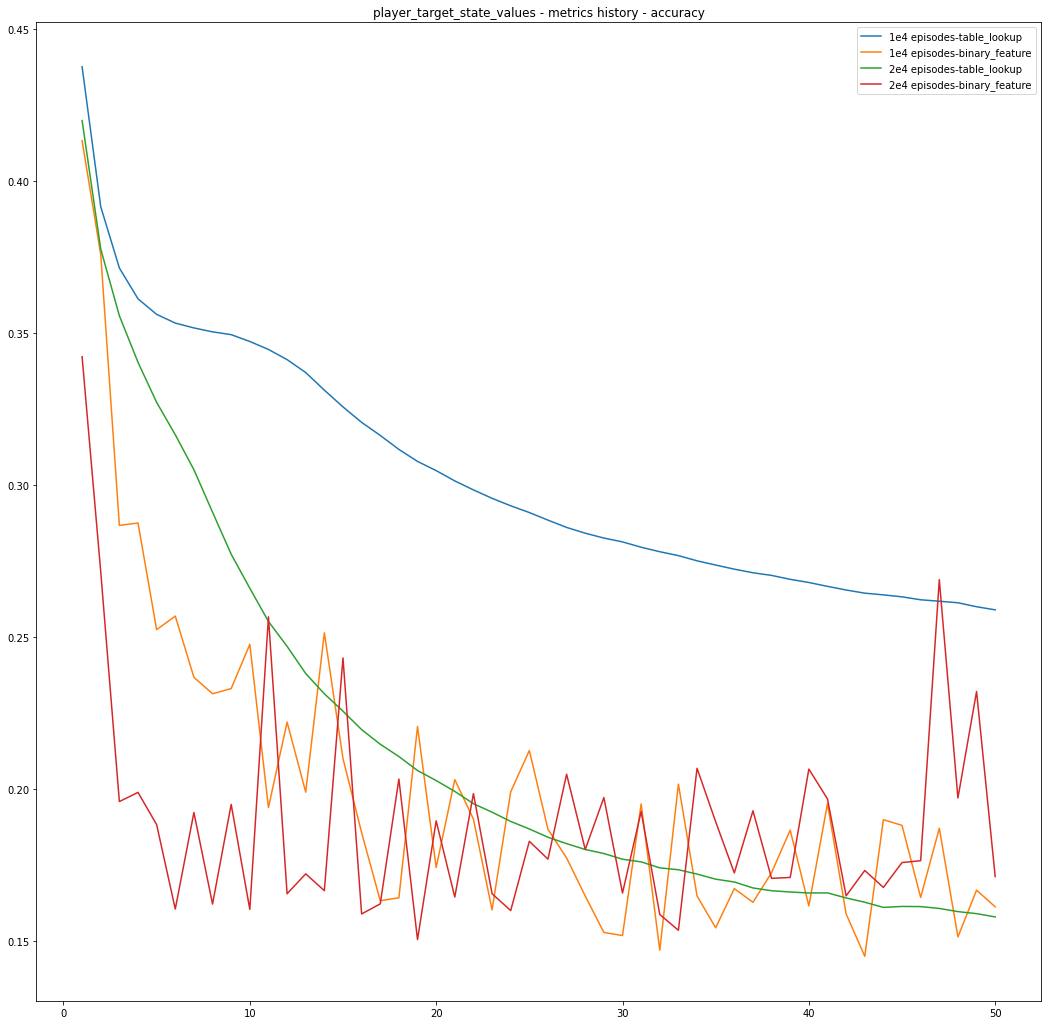

In [1]:
# TASK:
# - check table_lookup/full_binary_feature x sample_size ~ converge
#
# PROCESS;
# - sample different EPISODES experiences with with table_lookup/full_binary_feature
# - replay experience to fit with value approximator
# - check accuracy history
#
# RESULTS:
# - for 1e4 EPISODES, 2e4 EPISODES binary_feature doesn't show much difference
#   in accuracy
# - for 1e4 EPISODES, 2e4 EPISODES table_lookup show obviously better accuracy
#   with more samples
#
# INTERPRETATION:
# - linear combination of features has certain limit of accuracy as well as
#   some limitation in absorb new information from more samples
#
# RUN:
# %%
import sys

sys.path.append("../")

from tqdm import trange
from random import shuffle

from src.module.model_free_agent import ModelFreeAgent

from src.easy_21.game import playout, ACTIONS, STATE_LABELS, PLAYER_STATES
from src.easy_21.feature_function import table_lookup, full_binary_feature

#
# hyperparameters and agent config
#

EPOCH = 50

PLAYER = ModelFreeAgent(
    "player",
    ACTIONS,
    STATE_LABELS,
    PLAYER_STATES,
    state_action_parser=table_lookup,
)
PLAYER.load_optimal_state_values()

PLAYER.target_state_value_store.metrics_methods[
    "accuracy"
] = PLAYER.target_state_value_store_accuracy_to_optimal

#
# process
#

for EPISODES in [int(1e4), int(2e4)]:
    for feature_function in [table_lookup, full_binary_feature]:

        PLAYER.action_value_store.reset()
        PLAYER.action_value_store.feature_function = feature_function

        experiences = [
            playout(player_policy=PLAYER.e_greedy_policy)[0] for _ in trange(EPISODES)
        ]

        for _ in trange(EPOCH):
            shuffle(experiences)
            PLAYER.forward_td_lambda_learning_offline_batch(experiences)

            PLAYER.target_state_value_store.record("accuracy", log=False)

        PLAYER.target_state_value_store.stack_metrics_history("accuracy")

labels = [
    "1e4 episodes-table_lookup",
    "1e4 episodes-binary_feature",
    "2e4 episodes-table_lookup",
    "2e4 episodes-binary_feature",
]
PLAYER.target_state_value_store.plot_metrics_history_stack(
    "accuracy",
    labels=labels,
)
